In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

### Device configuration

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Hyper parameters

In [3]:
num_epochs = 8
learning_rate = 0.1

### Image preprocessing modules

In [4]:
transform = transforms.Compose([transforms.Pad(4), 
                                transforms.RandomHorizontalFlip(), 
                                transforms.RandomCrop(32),
                                transforms.ToTensor()])

### Cifar-10 dataset and dataloader

In [5]:
train_dataset = torchvision.datasets.CIFAR10(download=True, root='./cifar10', train=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(download=True, root='./cifar10', train=False, transform=transforms.ToTensor())

train_dataloader = torch.utils.data.DataLoader(batch_size=128, dataset=train_dataset, num_workers=4, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(batch_size=128, dataset=test_dataset, num_workers=4, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


### 3*3 convolution

In [6]:
def conv_3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(kernel_size=3, 
                     in_channels=in_channels, 
                     out_channels=out_channels, 
                     stride=stride,  
                     bias=False,
                     padding=1)

### Residual block

In [7]:
class ResidualBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        
        self.conv1 = conv_3x3(in_channels, out_channels, stride)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        
        self.conv2 = conv_3x3(out_channels, out_channels)
        self.downsample = downsample
        
    def forward(self, x):

        residual = x
        
        x = self.conv1(x)
        x = self.bn(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn(x)
        
        if self.downsample:
            residual = self.downsample(residual)
            
        return self.relu(x + residual)

### ResNet

In [8]:
class ResNet(nn.Module):
    
    def __init__(self, block_class, n, num_classes=10):
        super(ResNet, self).__init__()
        
        self.n = n
        self.block_class = block_class
        
        self.conv = conv_3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        
        self.res_block_16channels = self.make_res_block(16, 16)
        self.res_block_32channels = self.make_res_block(16, 32, 2)
        self.res_block_64channels = self.make_res_block(32, 64, 2)
        
        self.avg_pool = nn.AvgPool2d(kernel_size=8)
        self.fc = nn.Linear(64, num_classes)
        
    def make_res_block(self, in_channels, out_channels, stride=1):
        
        layers = []
        
        # generate downsample block
        downsample = None
        if stride != 1:
            #downsample = nn.Sequential(nn.Conv2d(in_channels, out_channels, 1, stride, bias=False), nn.BatchNorm2d(out_channels))
            downsample = nn.Sequential(conv_3x3(in_channels, out_channels, stride=stride), nn.BatchNorm2d(out_channels))
        layers.append(self.block_class(in_channels, out_channels, stride, downsample))
    
        # generate other blocks
        for _ in range(self.n - 1):
            layers.append(self.block_class(out_channels, out_channels))
            
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        
        x = self.res_block_16channels(x)
        x = self.res_block_32channels(x)
        x = self.res_block_64channels(x)
        
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x

### Define models etc.

In [9]:
model = ResNet(ResidualBlock, 3).to(device)

optimizer = torch.optim.SGD(lr=learning_rate, momentum=0.9, weight_decay=0.0001, params=model.parameters())
criterion = nn.CrossEntropyLoss()

### Update learning rate

In [10]:
def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

### Evaluation function

In [11]:
def evaluate():
    
    model.eval()
    
    losses = []

    with torch.no_grad():

        total = 0
        correct = 0

        for images, labels in test_dataloader:

            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            loss = criterion(outputs, labels)
            losses.append(loss)
            
    return np.mean(losses)

### Train/Evaluate the model

In [12]:
train_losses = []
eval_losses = []

curr_lr = learning_rate

for epoch in range(num_epochs):
    
    total = 0
    correct = 0
    
    for i, (images, labels) in enumerate(train_dataloader):
        
        model.train()
        
        images = images.to(device)
        labels = labels.to(device)
        
        # forward
        outputs = model(images)
    
        # loss
        train_loss = criterion(outputs, labels)
        train_losses.append(train_loss)
        
        # backward
        model.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        # evaluation
        eval_loss = evaluate()
        eval_losses.append(eval_loss)
        
        print(train_loss, eval_loss)
        
    # update learning rate
    if (epoch + 1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)

tensor(2.3213, device='cuda:0') 2.3058808
tensor(2.2963, device='cuda:0') 2.3061752
tensor(2.3010, device='cuda:0') 2.3063636
tensor(2.2707, device='cuda:0') 2.3063161
tensor(2.3193, device='cuda:0') 2.3063347
tensor(2.2528, device='cuda:0') 2.3063996
tensor(2.1977, device='cuda:0') 2.3062987
tensor(2.1502, device='cuda:0') 2.3076816
tensor(2.0784, device='cuda:0') 2.2617528
tensor(2.2297, device='cuda:0') 2.29203
tensor(2.1609, device='cuda:0') 2.324542
tensor(2.1657, device='cuda:0') 2.1497939
tensor(2.0456, device='cuda:0') 2.1618145
tensor(2.0667, device='cuda:0') 2.4330113
tensor(2.1086, device='cuda:0') 4.5910087
tensor(2.0241, device='cuda:0') 5.1999364
tensor(2.0304, device='cuda:0') 3.823318
tensor(2.0097, device='cuda:0') 3.8759866
tensor(1.9169, device='cuda:0') 4.5507345
tensor(1.9485, device='cuda:0') 5.8358607
tensor(1.9640, device='cuda:0') 3.905433
tensor(2.0229, device='cuda:0') 3.3438177
tensor(2.1195, device='cuda:0') 3.387295
tensor(1.9639, device='cuda:0') 3.269342

### Plot training curve

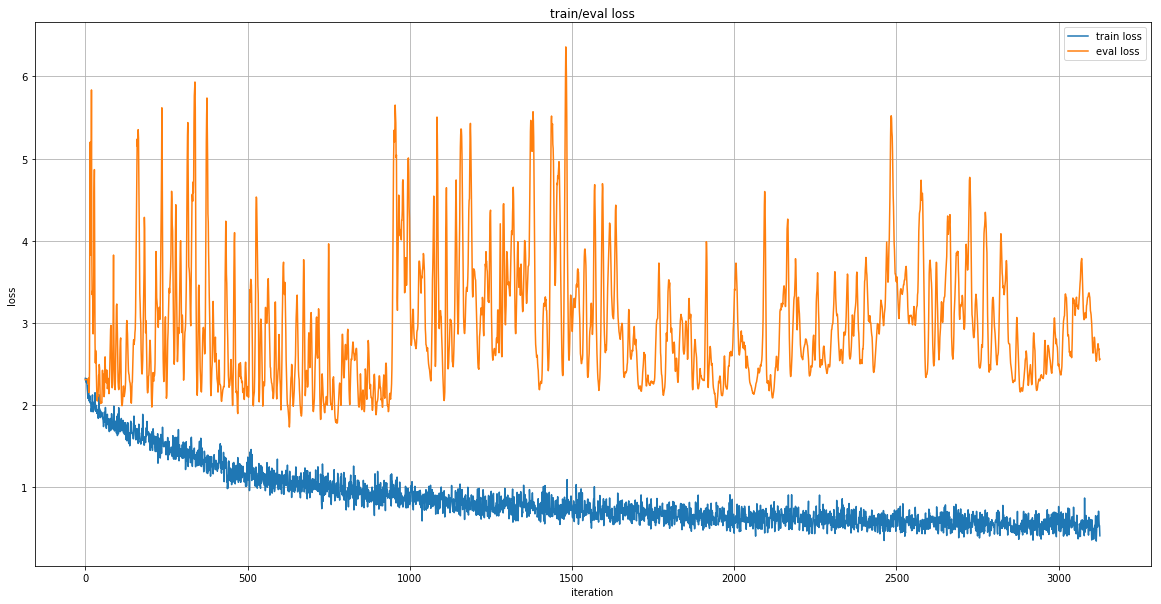

In [13]:
plt.figure(figsize=(20, 10))

plt.plot(train_losses, label='train loss')
plt.plot(eval_losses, label='eval loss')
plt.legend()

plt.title('train/eval loss')

plt.xlabel('iteration')
plt.ylabel('loss')

plt.grid(True)

### Test the model

In [14]:
model.eval()

with torch.no_grad():

    total = 0
    correct = 0

    for images, labels in test_dataloader:

        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        _, prediction = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (prediction == labels).sum().item()

    acc =  correct / total
    print('test accuracy: {}'.format(acc))

test accuracy: 0.1409
